In [14]:
import argparse
import numpy as np
import pickle
import time
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime


from dataset import get_dataloader,EventData
from tqdm import tqdm
import random
from models.gated_tpp import *
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

from models import sahp 


def load_data(name, dict_name):
    with open(name, 'rb') as f:
        data = pickle.load(f, encoding='latin-1')
        num_types = data['dim_process']
        data = data[dict_name]
        return data, int(num_types)

## Conditional GAN

99

In [74]:
data = '../data/simulated/power_hawkes/'
batch_size = 1



train_data, num_types = load_data(data + 'train.pkl', 'train')
dev_data, _ = load_data(data + 'dev.pkl', 'dev')
test_data, _ = load_data(data + 'test.pkl', 'test')

t_max = 1


trainloader = get_dataloader(train_data, 10, shuffle=True,t_max =t_max)
testloader = get_dataloader(test_data,1, shuffle=False,t_max = t_max)
valloader = get_dataloader(dev_data, 1, shuffle=False,t_max =t_max)

model = gated_tpp(num_types,16,32,dropout= 0.1,kernel_type='rational_quadratic',
                  length_scale=0.2,alpha=0.6,sigma = 0.1,timetovec=True)
device = 'cpu'
# model.load_state_dict(torch.load('trained_models/20210929_033634.pt'))

# stated_dict = torch.load('trained_embeddings/timetovec' +str(128)+  '.pt')
# model.encoder.embedding.load_state_dict(stated_dict)


In [83]:
valid_events = 0
train_events = 0
for seq in valloader.dataset.event_type:
    valid_events += len(seq)
    
for seq in trainloader.dataset.event_type:
    train_events += len(seq)
valid_events

21338

In [82]:
train_events = 0

for seq in train_data:
    train_events += len(seq)
train_events

169435

In [88]:
time.time()

1633849935.1028097

### Add Loss

In [16]:
for batch in trainloader:
    pass

In [17]:
scores, embeddings, _  = model.encoder(batch[2],batch[0],batch[1])
hidden = torch.matmul(scores, embeddings)
hidden = model.norm(hidden)

In [18]:
intensity = model.decoder.GAN
intensity(hidden)

In [25]:
dt_seq = batch[1]
seq_types = batch[2]

seq_onehot_types = seq_types -1
seq_onehot_types[seq_onehot_types<0] = model.num_types
seq_onehot_types = sahp.one_hot_embedding(seq_onehot_types,model.num_types+1)

intensity._compute_loss(dt_seq,seq_onehot_types)

tensor(1733.6035, grad_fn=<SumBackward0>)

In [46]:
dt_seq =batch[1]
dt_seq[0][:length]

tensor([1.4557e+01, 2.9407e-02, 1.5623e+00, 1.1958e+01, 1.6583e+01, 4.4800e+01,
        9.3425e-01, 1.0270e+00, 5.2232e+00, 4.6612e+00, 5.7947e+00, 9.1721e+00,
        3.6837e+00, 7.3817e-01, 1.7497e+00, 2.2048e+00, 1.0324e+00, 2.8561e+00,
        5.8741e+00, 2.2691e-01, 1.2728e+01, 1.6174e+01, 1.7266e+01, 5.7581e-01,
        1.5617e-01, 1.9155e+00, 1.4009e+00, 3.0396e-01, 3.0453e-02, 9.6356e+00,
        2.9956e-01])

In [49]:
dt_seq

tensor([[1.4557e+01, 2.9407e-02, 1.5623e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.1242e+00, 3.5171e+01, 7.4125e-03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.2417e+00, 4.3349e+00, 2.1503e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [2.0992e+01, 4.2071e+00, 5.6258e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.9064e+00, 7.3811e+00, 1.2294e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.0977e+00, 1.0216e-01, 3.5453e-01,  ..., 1.3000e+00, 4.8703e-01,
         5.4412e-02]])

In [61]:
seq_lengths = (batch[2]!=0).sum(-1)
dt_seq =batch[1]
seq_types = batch[2]
pad = 1
hmax = 200
n_samples = 100

index = 0
length = seq_lengths[index].item()  # exclude the first added event
dt_seq =dt_seq[index]
seq_types = seq_types[index]

dt_seq_valid = dt_seq[:length]  # exclude the last timestamp
dt_seq_used = dt_seq_valid[:length - 1]  # exclude the last timestamp
next_dt = dt_seq_valid[length - 1]

seq_types_valid = seq_types[:length + 1]  # include the first added event
last_type = seq_types[length - 1]
next_type = seq_types[length]

seq_types_used = seq_types_valid[:-1]
seq_types_valid_masked = sahp.MaskBatch(seq_types_used[None, :], pad, device)
seq_types_used_mask = seq_types_valid_masked.src_mask

with torch.no_grad():
    
    model.forward(dt_seq_used, seq_types_used)
    converge_point = torch.squeeze(intensity.converge_point)[-1, :]
    start_point = torch.squeeze(intensity.start_point)[-1, :]
    omega = torch.squeeze(intensity.omega)[-1, :]
    
    
    dt_vals = torch.linspace(0, hmax, n_samples + 1).to(device)
    h_t_vals = intensity.state_decay(converge_point,
                                start_point,
                                omega,
                                dt_vals[:, None])


TypeError: forward() missing 1 required positional argument: 'arrival_times'

In [62]:
dt_seq_used

tensor([1.4557e+01, 2.9407e-02, 1.5623e+00, 1.1958e+01, 1.6583e+01, 4.4800e+01,
        9.3425e-01, 1.0270e+00, 5.2232e+00, 4.6612e+00, 5.7947e+00, 9.1721e+00,
        3.6837e+00, 7.3817e-01, 1.7497e+00, 2.2048e+00, 1.0324e+00, 2.8561e+00,
        5.8741e+00, 2.2691e-01, 1.2728e+01, 1.6174e+01, 1.7266e+01, 5.7581e-01,
        1.5617e-01, 1.9155e+00, 1.4009e+00, 3.0396e-01, 3.0453e-02, 9.6356e+00])

In [156]:
dt_seq = batch[1]
seq_types = batch[2]

seq_onehot_types = seq_types -1
seq_onehot_types[seq_onehot_types<0] = model.num_types
seq_onehot_types = sahp.one_hot_embedding(seq_onehot_types,model.num_types+1)

seq_mask = seq_onehot_types[:,:,:-1]!=0

n_mc_samples=20

In [173]:
cell_t = intensity.state_decay(intensity.converge_point, intensity.start_point, intensity.omega, dt_seq[:, :, None])


n_batch = dt_seq.size(0)
n_times = dt_seq.size(1)


device = dt_seq.device
# Get the intensity process
intens_at_evs = intensity.intensity_layer(cell_t)
log_intensities = intens_at_evs.log() 
log_intensities = log_intensities * seq_onehot_types.sum(dim=-1).unsqueeze(-1)

log_sum = (log_intensities*seq_mask).sum(dim=(2, 1))

taus = torch.rand(n_batch, n_times, 1, n_mc_samples).to(device)  # self.process_dim replaced 1
taus = dt_seq[:, :, None, None] * taus  # inter-event times samples)

cell_tau = intensity.state_decay(
    intensity.converge_point[:, :, :, None],
    intensity.start_point[:, :, :, None],
    intensity.omega[:, :, :, None],
    taus)
cell_tau = cell_tau.transpose(2, 3)
intens_at_samples = intensity.intensity_layer(cell_tau).transpose(2, 3)

intens_at_samples = intens_at_samples * seq_onehot_types.sum(dim=-1).unsqueeze(-1).unsqueeze(-1)

total_intens_samples = intens_at_samples.sum(dim=2)  # shape batch * N * MC
partial_integrals = dt_seq * total_intens_samples.mean(dim=2)

integral_ = partial_integrals.sum(dim=1)

res = torch.sum(- log_sum + integral_)

In [174]:
res

tensor(1376.9716, grad_fn=<SumBackward0>)

In [114]:

log_sum = (log_intensities * seq_onehot_types).sum(dim=(2, 1))  # shape batch


tensor([-35.7117, -35.7199, -35.1815, -35.8361, -36.2106, -33.8285, -33.1584,
        -34.4691, -35.6415, -35.4722], grad_fn=<SumBackward1>)

In [118]:
(seq_onehot_types[0]*log_intensities[0]).sum(0)


tensor([-28.3778,  -7.3338], grad_fn=<SumBackward1>)

In [124]:
seq_types.shape

torch.Size([10, 60])

In [119]:
(seq_onehot_types[0]*log_intensities[0]).sum(dim=(2, 1))

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [125]:
[seq_onehot_types][0]

tensor([[[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [0., 1.],
         [0., 1.],
         [0., 1.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [0., 1.],
         [0., 1.],
         [0., 1.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [0., 1.],
         [0., 1.],
         [0., 1.]],

        ...,

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [0., 1.],
         [0., 1.],
         [0., 1.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [0., 1.],
         [0., 1.],
         [0., 1.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [0., 1.],
         [0., 1.],
         [0., 1.]]])

In [78]:
sahp.one_hot_embedding(batch[2],2)

tensor([[[0., 1.],
         [0., 1.],
         [0., 1.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        [[0., 1.],
         [0., 1.],
         [0., 1.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        [[0., 1.],
         [0., 1.],
         [0., 1.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        ...,

        [[0., 1.],
         [0., 1.],
         [0., 1.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        [[0., 1.],
         [0., 1.],
         [0., 1.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        [[0., 1.],
         [0., 1.],
         [0., 1.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]]])

In [27]:
batch[1][0]

tensor([ 3.9398, 13.3482,  1.3325,  2.5086, 17.3264,  1.0585,  0.0804,  0.7130,
        10.0187,  0.4091,  0.7611, 10.0527,  0.8724, 10.5322,  1.1079,  3.0732,
         2.7017,  3.7527,  1.7931,  5.6196,  1.5199,  0.8446,  1.0398,  0.7404,
         0.3761,  0.4201,  4.9036, 14.9053,  0.2449,  2.2392,  0.2570,  1.0658,
         2.2649,  0.7213,  0.8230, 17.7064, 15.6817,  0.4546,  3.3991,  0.0316,
         0.6112,  1.6714, 11.1630,  5.4092,  0.1624,  0.9543,  6.8788,  2.5249,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000])

In [26]:
model.decoder.GAN._compute_loss(batch[0],batch[0])

TypeError: _compute_loss() missing 1 required positional argument: 'seq_onehot_types'

In [5]:
    
event_type = batch[2]
length = event_type.sum()
event_time = batch[0]
arrival_time = batch[1]
intensities = batch[-1][0]
    

In [9]:
scores, embedding,t_diff = model.encoder(event_type,event_time,arrival_time)
hidden = torch.matmul(scores, embedding)

hidden = model.norm(hidden)
b_n, s_n, h_n = hidden.size()

util\kernel_functions.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = F.softmax(self.alpha)


In [28]:
sample = 50
noise = torch.rand((b_n, s_n,sample, h_n), device=hidden.device)

In [43]:
noise_sampled = model.decoder.GAN.noise_weights(noise)
hidden_samples = torch.relu(noise_sampled +model.decoder.GAN.input_weights(hidden)[:,:,None,:])
times = nn.functional.softplus(model.decoder.GAN.event_time_calculator(hidden_samples)).squeeze(-1).mean(-1)

In [39]:
hidden_sample = torch.relu(model.decoder.GAN.input_weights(hidden))

nn.functional.softplus(model.decoder.GAN.event_time_calculator(hidden_sample)).squeeze(-1).shape

torch.Size([10, 87])

In [3]:
kernel_values = []
all_times = []
all_intensities = []
all_predicted_intensities = []

model = model.to(device)

for batch in testloader:
    
    event_type = batch[2]
    length = event_type.sum()
    event_time = batch[0]
    arrival_time = batch[1]
    intensities = batch[-1][0]
    
    
    
    event_time, arrival_time, event_type,_ = map(lambda x: x.to(device), batch)
    scores, embedding,t_diff = model.encoder(event_type,event_time,arrival_time)
    scores = model.encoder.scores
        
    predicted_intensities=scores.sum(-1)[0]
        
    masked_t_diff = (t_diff[0][:length,:length])
    masked_scores = (scores[0][:length,:length])
    row,column = masked_t_diff.size()
    row,column = torch.tril_indices(row,column)
    times = masked_t_diff[row,column]
    triggering_values=  masked_scores[row,column]
    
    kernel_values.append(triggering_values.detach())
    all_times.append(times.detach())
    all_intensities.append(intensities.detach())
    all_predicted_intensities.append(predicted_intensities.detach())
    
kernel_values = torch.cat(kernel_values)
all_times = torch.cat(all_times)
all_intensities = torch.cat(all_intensities)
all_predicted_intensities = torch.cat(all_predicted_intensities)

In [87]:
((all_predicted_intensities- all_intensities)**2).mean().sqrt()

tensor(0.4237)

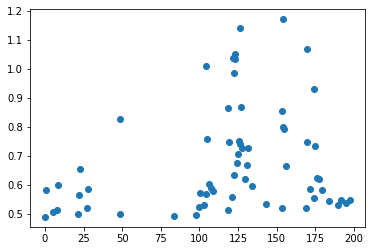

In [83]:
plt.scatter(event_time[0],scores.sum(-1)[0])

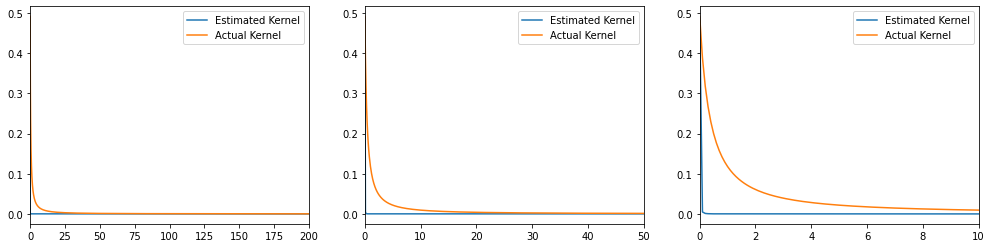

In [88]:

times = torch.arange(0,200,0.1).unsqueeze(0)


types = torch.ones(times.size()).to(times.device).int()
scores, embedding,t_diff = model.encoder(types,times,times)
scores = scores[0][-1]
t =t_diff[0][-1]
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(17,4))
actual_alpha =  power_law_kernel(t).squeeze()

ax1.plot(t_diff[0][-1],scores,label='Estimated Kernel')
ax1.plot(t,actual_alpha,label='Actual Kernel')
ax1.set_xlim(0, 200)
ax1.legend()

ax2.plot(t_diff[0][-1],scores,label='Estimated Kernel')
ax2.plot(t,actual_alpha,label='Actual Kernel')
ax2.set_xlim(0, 50)
ax2.legend()


ax3.plot(t_diff[0][-1],scores,label='Estimated Kernel')
ax3.plot(t,actual_alpha,label='Actual Kernel')
ax3.set_xlim(0, 10)
ax3.legend()

In [69]:
t_diff[0][-1]

tensor([1.9990e+02, 1.9980e+02, 1.9970e+02,  ..., 2.0000e-01, 9.9991e-02,
        0.0000e+00])

In [4]:
for batch in trainloader:
    pass

In [70]:
t

tensor([1.9990e+02, 1.9980e+02, 1.9970e+02,  ..., 2.0000e-01, 9.9991e-02,
        0.0000e+00])

In [60]:
scores

tensor([3.0636e-04, 3.0667e-04, 3.0698e-04,  ..., 4.8922e-01, 4.8980e-01,
        4.9000e-01])

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x00000196A01285E8> (for post_execute):


KeyboardInterrupt: 

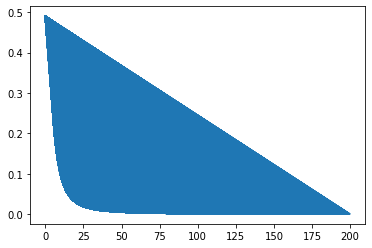

In [9]:
plt.plot(all_times,kernel_values)

In [32]:
scores, embeddings,t_diff = model.encoder(event_type,event_time,arrival_time)
hidden = torch.matmul(scores, embeddings)
hidden = model.norm(hidden)
scores = model.encoder.scores


(0.0, 200.0)

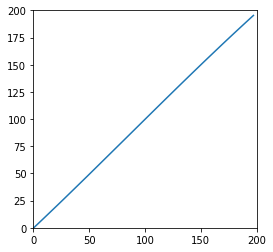

In [70]:

# times = torch.arange(0,200,0.01).unsqueeze(0)

times = event_time
time_0 = torch.zeros(times.size()).to(times.device)


    
embeddings =   model.encoder.embedding(None,times)
s = torch.abs(embeddings[0] - embeddings[0][0]).sum(-1).detach()
d = times[0] 


fig, ax1 = plt.subplots(1, 1,figsize=(4,4))
ax1.plot(d,s)
ax1.set_xlim(0, 200)
ax1.set_ylim(0, 200)

In [86]:
embeddings

tensor([[[-7.4846e-02,  4.3890e-01,  3.5670e-01,  ...,  4.1202e-01,
           3.5769e-01,  3.2186e-01],
         [-3.2545e-01,  4.3638e-01,  3.5411e-01,  ...,  4.0947e-01,
           3.5510e-01,  3.1925e-01],
         [-2.0280e+00,  4.1916e-01,  3.3644e-01,  ...,  3.9209e-01,
           3.3744e-01,  3.0144e-01],
         ...,
         [-8.0596e+01, -4.3180e-01, -5.0173e-01,  ..., -4.5531e-01,
          -5.0092e-01, -5.2969e-01],
         [-8.2031e+01, -4.4622e-01, -5.1539e-01,  ..., -4.6949e-01,
          -5.1459e-01, -5.4301e-01],
         [-8.2962e+01, -4.5552e-01, -5.2418e-01,  ..., -4.7863e-01,
          -5.2339e-01, -5.5158e-01]]], grad_fn=<CopySlices>)

In [83]:
torch.abs(embeddings[0][1] -embeddings[0][2]).sum()

tensor(3.9238, grad_fn=<SumBackward0>)

In [85]:
times

tensor([[  0.3487,   0.9439,   4.9879,   7.8555,   8.4748,  21.5842,  22.3889,
          22.8649,  27.3166,  28.0844,  48.4917,  48.6421,  83.2685,  98.0624,
          99.6606, 100.5524, 102.9888, 104.0684, 104.1318, 104.6314, 106.0621,
         107.4788, 109.0570, 118.4745, 118.6092, 119.0385, 121.3596, 121.3907,
         122.4604, 122.5845, 122.7878, 123.0429, 124.3421, 125.0073, 125.5275,
         126.1483, 126.2327, 126.7296, 127.6744, 129.7685, 130.5333, 131.0835,
         133.7563, 143.1940, 153.4572, 153.6021, 153.9515, 154.0334, 154.6132,
         155.6522, 169.0870, 169.3333, 169.4405, 171.3086, 173.9252, 174.0391,
         174.5800, 175.8798, 177.0236, 179.0844, 183.8156, 189.4532, 191.6038,
         195.0111, 197.2229]])

In [61]:
model.encoder.embedding.Wt(torch.Tensor([0]))-model.encoder.embedding.Wt(torch.Tensor([1]))

tensor([ 4.7632,  0.0533,  0.0527,  0.0531,  0.0534, -0.0524, -0.0527, -0.0523,
        -0.0532, -0.0533,  0.0531, -0.0534, -0.0531, -0.0526, -0.0535,  0.0525,
         0.0535,  0.0534, -0.0531, -0.0522, -0.0526,  0.0533,  0.0526, -0.0528,
        -0.0527,  0.0532,  0.0529, -0.0532, -0.0528,  0.0521,  0.0525, -0.0527,
        -0.0527, -0.0529,  0.0533,  0.0537,  0.0527,  0.0532,  0.0523, -0.0529,
         0.0526,  0.0522,  0.0530, -0.0528, -0.0526,  0.0530,  0.0524,  0.0535,
        -0.0532, -0.0520, -0.0533, -0.0526, -0.0524, -0.0527,  0.0530, -0.0534,
         0.0531, -0.0533,  0.0526,  0.0531,  0.0526,  0.0524,  0.0533, -0.0529,
         0.0523, -0.0534,  0.0536, -0.0526, -0.0523,  0.0530,  0.0529, -0.0531,
        -0.0524, -0.0529, -0.0534, -0.0527,  0.0534, -0.0528, -0.0529, -0.0535,
        -0.0525,  0.0526, -0.0534,  0.0531,  0.0529,  0.0520, -0.0529, -0.0528,
        -0.0532,  0.0528,  0.0531, -0.0535, -0.0533, -0.0534, -0.0523,  0.0525,
         0.0526, -0.0530, -0.0533,  0.05

In [55]:
torch.abs(model.encoder.embedding.Wt(torch.Tensor([0])) - model.encoder.embedding.Wt(torch.Tensor([4.9879]))).sum()

tensor(57.2658, grad_fn=<SumBackward0>)

In [23]:
event_time

tensor([[  0.3487,   0.9439,   4.9879,   7.8555,   8.4748,  21.5842,  22.3889,
          22.8649,  27.3166,  28.0844,  48.4917,  48.6421,  83.2685,  98.0624,
          99.6606, 100.5524, 102.9888, 104.0684, 104.1318, 104.6314, 106.0621,
         107.4788, 109.0570, 118.4745, 118.6092, 119.0385, 121.3596, 121.3907,
         122.4604, 122.5845, 122.7878, 123.0429, 124.3421, 125.0073, 125.5275,
         126.1483, 126.2327, 126.7296, 127.6744, 129.7685, 130.5333, 131.0835,
         133.7563, 143.1940, 153.4572, 153.6021, 153.9515, 154.0334, 154.6132,
         155.6522, 169.0870, 169.3333, 169.4405, 171.3086, 173.9252, 174.0391,
         174.5800, 175.8798, 177.0236, 179.0844, 183.8156, 189.4532, 191.6038,
         195.0111, 197.2229]])

In [42]:
k_scores[0][1]

tensor([ 4.4460e-01,  1.0000e+00, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10],
       device='cuda:0', grad_fn=<SelectBackward>)

In [10]:
kernel_values = []
all_times = []

model = model.to(device)

for batch in testloader:
    
    event_type = batch[2]
    length = event_type.sum()
    event_time = batch[0]
    arrival_time = batch[1]
    
    event_time, arrival_time, event_type,_ = map(lambda x: x.to(device), batch)
    scores, embedding,t_diff = model.encoder(event_type,event_time,arrival_time)
    scores = model.encoder.scores
        
    masked_t_diff = (t_diff[0][:length,:length])
    masked_scores = (scores[0][:length,:length])
    row,column = masked_t_diff.size()
    row,column = torch.tril_indices(row,column)
    times = masked_t_diff[row,column]
    triggering_values=  masked_scores[row,column]
    
    kernel_values.append(triggering_values.detach())
    all_times.append(times.detach())
    
kernel_values = torch.cat(kernel_values)
all_times = torch.cat(all_times)

In [11]:
event_time

tensor([[  0.3487,   0.9439,   4.9879,   7.8555,   8.4748,  21.5842,  22.3889,
          22.8649,  27.3166,  28.0844,  48.4917,  48.6421,  83.2685,  98.0624,
          99.6606, 100.5524, 102.9888, 104.0684, 104.1318, 104.6314, 106.0621,
         107.4788, 109.0570, 118.4745, 118.6092, 119.0385, 121.3596, 121.3907,
         122.4604, 122.5845, 122.7878, 123.0429, 124.3421, 125.0073, 125.5275,
         126.1483, 126.2327, 126.7296, 127.6744, 129.7685, 130.5333, 131.0835,
         133.7563, 143.1940, 153.4572, 153.6021, 153.9515, 154.0334, 154.6132,
         155.6522, 169.0870, 169.3333, 169.4405, 171.3086, 173.9252, 174.0391,
         174.5800, 175.8798, 177.0236, 179.0844, 183.8156, 189.4532, 191.6038,
         195.0111, 197.2229]])

In [16]:
torch.abs(embedding[0][0] -embedding[0][2]).sum()

tensor(19.8724, grad_fn=<SumBackward0>)

In [17]:
embedding

tensor([[[-0.0656, -0.0663, -0.1062,  ..., -0.0325,  0.0295, -0.0290],
         [-0.0505, -0.0609, -0.1257,  ..., -0.0464,  0.0183, -0.0296],
         [ 0.1597,  0.0146, -0.3910,  ..., -0.2383, -0.1386, -0.0381],
         ...,
         [ 0.0443, -0.0269, -0.2478,  ..., -0.1336, -0.0527, -0.0335],
         [ 0.1209,  0.0007, -0.3437,  ..., -0.2033, -0.1098, -0.0365],
         [ 0.0480, -0.0255, -0.2525,  ..., -0.1370, -0.0555, -0.0336]]],
       grad_fn=<CopySlices>)

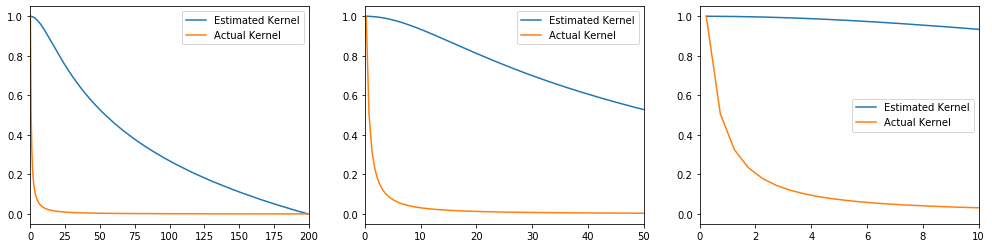

In [6]:
x = all_times.detach()
y = kernel_values.detach()

sorted_indices = torch.argsort(x)

x = x[sorted_indices]
y = y[sorted_indices]


## Moving Average

step = 0.5

t = []
alpha = []

for i in np.arange(step,200,step):
    avg_index = (x<i) & ( x >i - step)
    t.append(x[avg_index].mean().item())
    alpha.append(y[avg_index].mean().item())
alpha = np.array(alpha)
alpha = (alpha - alpha.min())/(alpha.max()-alpha.min())
actual_alpha = power_law_kernel(np.array(t))
actual_alpha = (actual_alpha - actual_alpha.min())/(actual_alpha.max()-actual_alpha.min())

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(17,4))

ax1.plot(t,alpha,label='Estimated Kernel')
ax1.plot(t,actual_alpha,label='Actual Kernel')
ax1.set_xlim(0, 200)
ax1.legend()

ax2.plot(t,alpha,label='Estimated Kernel')
ax2.plot(t,actual_alpha,label='Actual Kernel')
ax2.set_xlim(0, 50)
ax2.legend()


ax3.plot(t,alpha,label='Estimated Kernel')
ax3.plot(t,actual_alpha,label='Actual Kernel')
ax3.set_xlim(0, 10)
ax3.legend()

plt.show()

In [189]:
torch.clone(model.encoder)

TypeError: clone(): argument 'input' (position 1) must be Tensor, not Encoder

In [20]:
def power_law_kernel(t):  
    
    return 0.2 * (0.5 + t)**(-1.3)


def get_moving_average(times,scores,step = 0.15,max_t = 200):
    
    t = []
    alpha = []
    
    index= 0
    for i in np.arange(step,max_t,step):
        avg_index = (x<i) & ( x >i - step)
        t.append(x[avg_index].mean().item())
        alpha.append(y[avg_index].mean().item())
    
    zero_avg_index = x ==0
    t.insert(0,x[zero_avg_index].mean().item())
    alpha.insert(0,y[zero_avg_index].mean().item())
    
    
    return np.array(t),np.array(alpha) 


def get_triggering_kernel_values(model,device ='cpu'):
    
    encoder = model.encoder.to(device)

    normalized_event_time = torch.arange(0,200,0.1).unsqueeze(0).to(device)
    event_type = torch.ones(normalized_event_time.size(-1)).long().unsqueeze(0).to(device)

    type_embedding = encoder.type_emb(event_type) * math.sqrt(model.d_model)

    subsequent_mask = get_subsequent_mask(event_type)

    xt_bar = normalized_event_time.unsqueeze(1). \
        expand(normalized_event_time.size(0), normalized_event_time.size(1), normalized_event_time.size(1))
    xt = xt_bar.transpose(1, 2)


    xd_bar = type_embedding.unsqueeze(1).expand(type_embedding.size(
        0), type_embedding.size(1), type_embedding.size(1), type_embedding.size(-1))
    xd = xd_bar.transpose(1, 2)


    scores = encoder.kernel((xt, xt_bar), (xd, xd_bar))* (encoder.sigmoid((xt, xt_bar), (xd, xd_bar)))

    length = event_type.sum()
    t_diff = torch.abs(xt - xt_bar)


    masked_t_diff = (t_diff[0][:length,:length])
    masked_scores = (scores[0][:length,:length])
    row,column = masked_t_diff.size()
    row,column = torch.tril_indices(row,column)
    times = masked_t_diff[row,column]
    triggering_values=  masked_scores[row,column]

    x = times.detach()
    y = triggering_values.detach()

    sorted_indices = torch.argsort(x)

    x = x[sorted_indices]
    y = y[sorted_indices]
    
    return x,y



def plot_triggering_kernel_vs_actual_kernels(model,kernel_function,device = 'cpu',step = 0.25 ):
    
    times, scores = get_triggering_kernel_values(model,device = 'cpu')
    t,alpha = get_moving_average(times,scores,step = step)
    
    
    alpha = (alpha - alpha.min())/(alpha.max()-alpha.min())
    actual_alpha = kernel_function(np.array(t))
    actual_alpha = (actual_alpha - actual_alpha.min())/(actual_alpha.max()-actual_alpha.min())
    
    
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(17,4))

    ax1.plot(t,alpha,label='Estimated Kernel')
    ax1.plot(t,actual_alpha,label='Actual Kernel')
    ax1.set_xlim(0, 200)
    ax1.legend()

    ax2.plot(t,alpha,label='Estimated Kernel')
    ax2.plot(t,actual_alpha,label='Actual Kernel')
    ax2.set_xlim(0, 25)
    ax2.legend()


    ax3.plot(t,alpha,label='Estimated Kernel')
    ax3.plot(t,actual_alpha,label='Actual Kernel')
    ax3.set_xlim(0, 6)
    ax3.legend()

    plt.show()
    

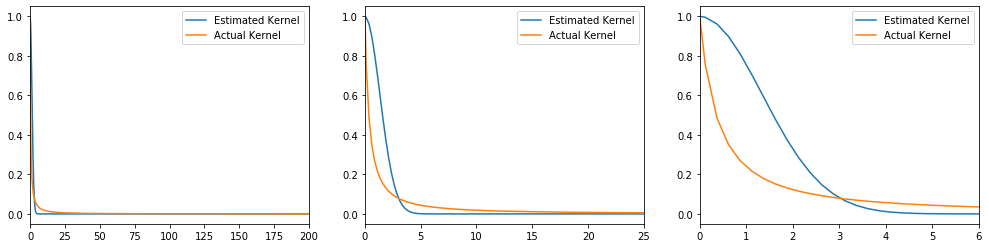

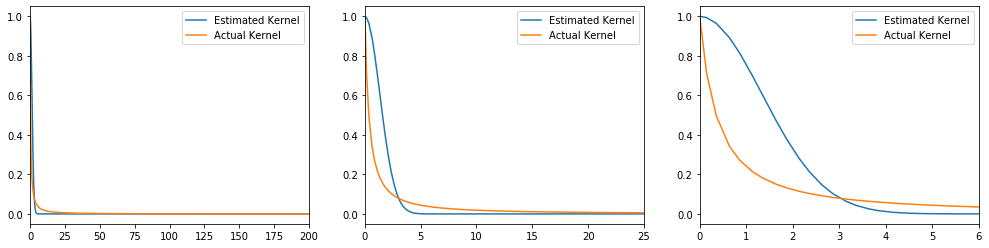

In [166]:
## Moving Average


alpha = (alpha - alpha.min())/(alpha.max()-alpha.min())
actual_alpha = power_law_kernel(np.array(t))
actual_alpha = (actual_alpha - actual_alpha.min())/(actual_alpha.max()-actual_alpha.min())

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(17,4))

ax1.plot(t,alpha,label='Estimated Kernel')
ax1.plot(t,actual_alpha,label='Actual Kernel')
ax1.set_xlim(0, 200)
ax1.legend()

ax2.plot(t,alpha,label='Estimated Kernel')
ax2.plot(t,actual_alpha,label='Actual Kernel')
ax2.set_xlim(0, 25)
ax2.legend()


ax3.plot(t,alpha,label='Estimated Kernel')
ax3.plot(t,actual_alpha,label='Actual Kernel')
ax3.set_xlim(0, 6)
ax3.legend()

plt.show()

## Event Predictions

### RMSE Calculations

In [167]:
last_errors = []
all_errors = []
all_predictions = []
all_arrivals = []
for batch in testloader:
    

    event_type = batch[2]
    event_time = batch[0]
    arrival_time = batch[1]
    
    event_time, arrival_time, event_type,_ = map(lambda x: x.to(device), batch)

    
    predicted_times = model(event_type,event_time)


    last_event_index = event_type.sum(-1)-2
    errors = predicted_times[:, :-1] - arrival_time[:, 1:]
    seq_index = 0
    for idx in last_event_index:
        last_errors.append(errors[seq_index][idx].unsqueeze(-1))
        all_errors.append(errors[seq_index][:idx+1])
        all_predictions.append(predicted_times[:, :-1][:idx+1].squeeze(0))
        all_arrivals.append(arrival_time[:, :-1][:idx+1].squeeze(0))
last_errors = torch.cat(last_errors)
last_RMSE =(last_errors**2).mean().sqrt()

all_predictions = torch.cat(all_predictions)
all_arrivals = torch.cat(all_arrivals)


all_errors = torch.cat(all_errors)
all_RMSE = (all_errors**2).mean().sqrt()



RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking arugment for argument index in method wrapper_index_select)

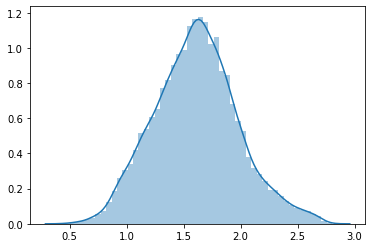

In [8]:
sns.distplot(all_predictions.cpu().detach())

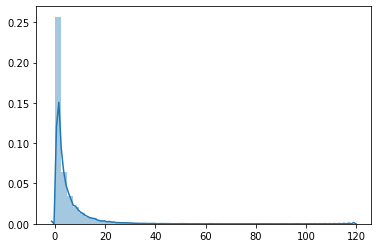

In [9]:
sns.distplot(all_arrivals.cpu().detach())

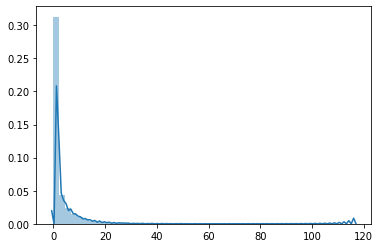

In [10]:
sns.distplot(np.abs(all_errors.to('cpu').detach()))

In [ ]:
(tensor(0.2037, grad_fn=<SelectBackward>),
 tensor(0.6250, grad_fn=<SelectBackward>))

## Sin Hawkes

In [16]:
data = '../data/simulated/sin_hawkes/'
batch_size = 1
def load_data(name, dict_name):
    with open(name, 'rb') as f:
        data = pickle.load(f, encoding='latin-1')
        num_types = data['dim_process']
        data = data[dict_name]
        return data, int(num_types)

train_data, num_types = load_data(data + 'train.pkl', 'train')
dev_data, _ = load_data(data + 'dev.pkl', 'dev')
test_data, _ = load_data(data + 'test.pkl', 'test')


trainloader = get_dataloader(train_data, batch_size, shuffle=True)
testloader = get_dataloader(test_data, 1, shuffle=False)
valloader = get_dataloader(dev_data, 1, shuffle=False)

t_max = max(max(max(valloader.dataset.time)), max(max(testloader.dataset.time)), max(max(trainloader.dataset.time)))

model = gated_TPP(num_types,32, t_max=t_max,dropout= 0.1)
device = 'cuda'
model.load_state_dict(torch.load('trained_models/sin_hawkesdebug_model.pt'))

<All keys matched successfully>

In [17]:
model.encoder.kernel.length_scale(model.encoder.type_emb.weight)[-1]

tensor([2.2018], grad_fn=<SelectBackward>)

In [18]:
model.encoder.sigmoid.params(model.encoder.type_emb.weight)[-1]

tensor([0.9698, 0.0782], grad_fn=<SelectBackward>)

In [19]:
kernel_values = []
all_times = []

model = model.to(device)

for batch in testloader:
    
    event_type = batch[2]
    length = event_type.sum()
    event_time = batch[0]
    arrival_time = batch[1]
    
    event_time, arrival_time, event_type,_ = map(lambda x: x.to(device), batch)
    scores, embedding,t_diff = model.encoder(event_type,event_time)
    scores = model.encoder.scores

    masked_t_diff = (t_diff[0][:length,:length])
    masked_scores = (scores[0][:length,:length])
    row,column = masked_t_diff.size()
    row,column = torch.tril_indices(row,column)
    times = masked_t_diff[row,column]
    triggering_values=  masked_scores[row,column]
    
    kernel_values.append(triggering_values.detach())
    all_times.append(times.detach())
    
kernel_values = torch.cat(kernel_values)
all_times = torch.cat(all_times)

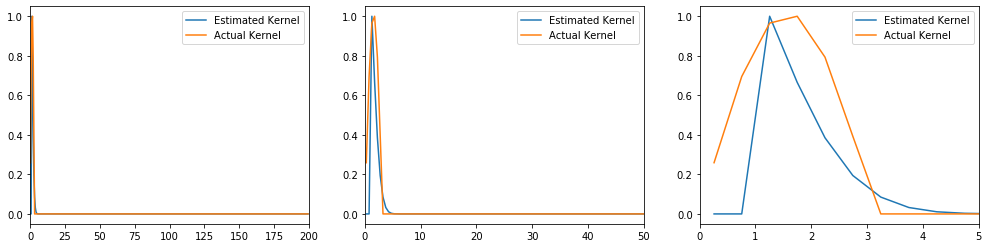

In [32]:
x = all_times.detach()
y = kernel_values.detach()

sorted_indices = torch.argsort(x)

x = x[sorted_indices]
y = y[sorted_indices]


def sin_kernel(t):
    

    t_c = np.copy(t)
    t_c[t_c>4] =0
    sin = np.sin(t_c)/8
    sin[sin <0] =0
    return sin


## Moving Average

step = 0.5

t = []
alpha = []

for i in np.arange(step,200,step):
    avg_index = (x<i) & ( x >i - step)
    t.append(x[avg_index].mean().item())
    alpha.append(y[avg_index].mean().item())
alpha = np.array(alpha)
alpha = alpha/alpha.max()
actual_alpha = sin_kernel(np.array(t))
actual_alpha = (actual_alpha - actual_alpha.min())/(actual_alpha.max()-actual_alpha.min())

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(17,4))

ax1.plot(t,alpha,label='Estimated Kernel')
ax1.plot(t,actual_alpha,label='Actual Kernel')
ax1.set_xlim(0, 200)
ax1.legend()

ax2.plot(t,alpha,label='Estimated Kernel')
ax2.plot(t,actual_alpha,label='Actual Kernel')
ax2.set_xlim(0, 50)
ax2.legend()


ax3.plot(t,alpha,label='Estimated Kernel')
ax3.plot(t,actual_alpha,label='Actual Kernel')
ax3.set_xlim(0, 5)
ax3.legend()

plt.show()

In [31]:
alpha.max()

1.2903988361358643

In [40]:
last_errors = []
all_errors = []
all_predictions = []
all_arrivals = []
for batch in testloader:
    

    event_type = batch[2]
    event_time = batch[0]
    arrival_time = batch[1]
    
    event_time, arrival_time, event_type,_ = map(lambda x: x.to(device), batch)

    
    predicted_times = model(event_type,event_time)


    last_event_index = event_type.sum(-1)-2
    errors = predicted_times[:, :-1] - arrival_time[:, 1:]
    seq_index = 0
    for idx in last_event_index:
        last_errors.append(errors[seq_index][idx].unsqueeze(-1))
        all_errors.append(errors[seq_index][:idx+1])
        all_predictions.append(predicted_times[:, :-1][:idx+1].squeeze(0))
        all_arrivals.append(arrival_time[:, :-1][:idx+1].squeeze(0))
last_errors = torch.cat(last_errors)
last_RMSE =(last_errors**2).mean().sqrt()

all_predictions = torch.cat(all_predictions)
all_arrivals = torch.cat(all_arrivals)


all_errors = torch.cat(all_errors)
all_RMSE = (all_errors**2).mean().sqrt()



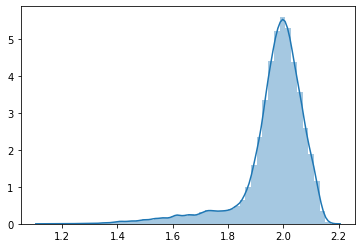

In [41]:
sns.distplot(all_predictions.cpu().detach())

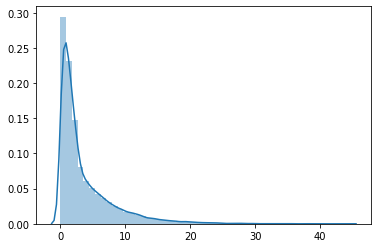

In [42]:
sns.distplot(all_arrivals.cpu().detach())

## Gate Experiments

In [ ]:
nn.ModuleList([nn.Parameter(),nn.Parameter()])

In [51]:
val_s

tensor([1.0000, 1.0000, 1.0000,  ..., 2.9397, 2.9406, 2.9415])

In [ ]:
nn.Parameter(torch.tensor(-0.1))

In [ ]:
nn.Sequential(nn.Parameter(torch.tensor([ 0.1] )), nn.Softplus())

In [ ]:
torch.softplus

In [13]:

def squared_exponential_kernel(x, sigma=10, lambd=0.01, norm=2):
    d = x ** norm

    return (sigma ** 2) * torch.exp(-(d ** 2) / lambd ** 2)


def sigmoid(x,l=0.1,s=0.1,b = 0.1,norm =2):
    d = x**norm
    return 1+torch.tanh((d-l)/s)

t =torch.arange(0,200,0.1)
val = squared_exponential_kernel(t,sigma = 2,lambd=2.1269,norm = 1)
val_s = sigmoid((t/200),l =0.000001,s= 0.000000111,norm =1)

plt.plot(t,F.softmax(val_s*val))
plt.xlim(0, 4)


C:\Users\yamac\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


(0, 4)

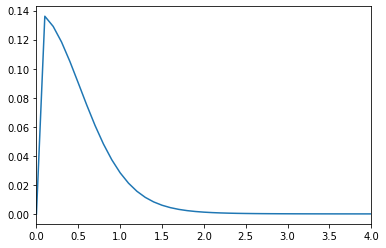

In [16]:
t =torch.arange(0,200,0.1)
val = squared_exponential_kernel(t,sigma = 2,lambd=2.1269,norm = 1)
val_s = sigmoid((t/200),l =0.000001,s= 0.000000111,norm =1)

plt.plot(t,F.softmax(val_s*val))
plt.xlim(0, 4)


In [7]:


def squared_exponential_kernel(x, sigma=1, lengthscale=0.01, norm=1):
    d = x ** norm

    return (sigma ** 2) * torch.exp(-(d ** 2) / lengthscale ** 2)


def rational_quadratic_kernel(x, sigma =1, alpha= 0.1, lengthscale = 0.01,norm = 1):
    d = x ** norm
    return (sigma ** 2) *(1+((d**2)/(alpha*lengthscale)))**(-alpha)


def power_law_kernel(t):  
    
    return 0.2 * (0.5 + t)**(-1.3)

In [8]:
t = torch.arange(0,200,0.1)

In [1]:
# values = squared_exponential_kernel(t,sigma= 1.0, lengthscale =  9.629205704)
values = rational_quadratic_kernel(t,sigma= 1.0, lengthscale =  0.7, alpha = 0.99)


values_sig = sig(t,l=  0.1501, s = 2.0866)


fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(17,4))


ax1.plot(t,values)
ax1.set_xlim(0, 100)

ax2.plot(t,values)
ax2.set_xlim(0, 25)

ax3.plot(t,values)
ax3.set_xlim(0, 3)


# final_scores =values_sig*values
# actual_scores = power_law_kernel(t)
# ax3.plot(t,final_scores/final_scores.max())
# ax3.plot(t,actual_scores/actual_scores.max())







NameError: name 'rational_quadratic_kernel' is not defined

(0, 10)

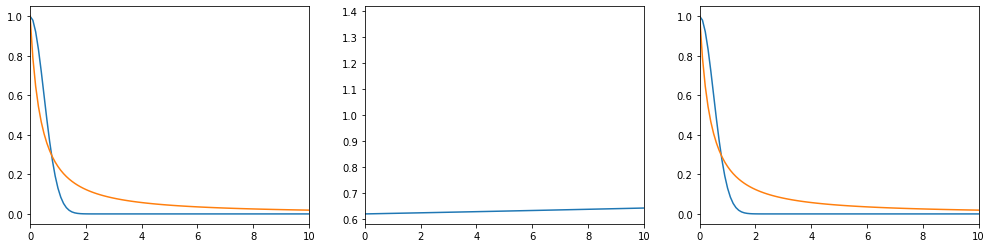

In [79]:
values = squared_exponential_kernel(t,sigma= 1.0, lengthscale =  0.7)
# values = rational_quadratic_kernel(t,sigma= 1.0, lengthscale =  0.1, alpha = 1.0)
values_sig = sig(t,l=  100, s = 100)


fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(17,4))

limit = 10

ax1.plot(t,values)
ax1.set_xlim(0, limit)
ax1.plot(t,actual_scores/actual_scores.max())


ax2.plot(t,values_sig)
ax2.set_xlim(0, limit)


final_scores =values_sig*values
actual_scores = power_law_kernel(t)
ax3.plot(t,final_scores/final_scores.max())
ax3.plot(t,actual_scores/actual_scores.max())


ax3.set_xlim(0, limit)





(0, 5)

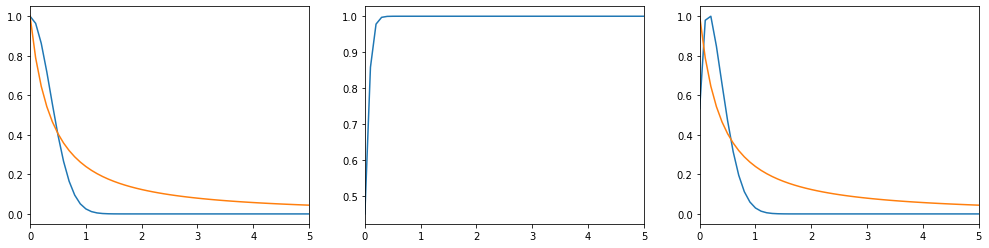

In [27]:
def sig(d,l,s):
    return 0.5+0.5*torch.tanh((d - l) / s)



values = squared_exponential_kernel(t,sigma= 1.0, lengthscale = 0.521527051925659)
# values = rational_quadratic_kernel(t,sigma= 1.0, lengthscale =0.768, alpha = 0.99)
values_sig = sig(t,l=  0.01, s = 0.1)


fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(17,4))

limit = 5

ax1.plot(t,values)
ax1.set_xlim(0, limit)
ax1.plot(t,actual_scores/actual_scores.max())


ax2.plot(t,values_sig)
ax2.set_xlim(0, limit)


final_scores =values_sig*values
actual_scores = power_law_kernel(t)
ax3.plot(t,final_scores/final_scores.max())
ax3.plot(t,actual_scores/actual_scores.max())


ax3.set_xlim(0, limit)





In [95]:
final_scores

tensor([-5.0000e-01, -4.9357e-01, -4.7525e-01,  ...,  1.0627e-05,
         1.0616e-05,  1.0606e-05])

## Finding Fixed Embeddings

In [ ]:

class BiasedPositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=4096):
        super().__init__()

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()
        self.register_buffer('position', position)
        self.register_buffer('div_term', div_term)

        self.Wt = nn.Linear(1, d_model // 2, bias=False)

    def forward(self, x, interval):
        phi = self.Wt(interval.unsqueeze(-1))
        aa = len(x.size())
        if aa > 1:
            length = x.size(1)
        else:
            length = x.size(0)

        # pe = torch.zeros(length, len(self.Wt.weight)).float()
        arc = (self.position[:length] * self.div_term).unsqueeze(0)
        pe_sin = torch.sin(arc + phi)
        pe_cos = torch.cos(arc + phi)
        pe = torch.cat([pe_sin, pe_cos], dim=-1)

        return pe


 Epoch:0, Loss:33.047489166259766
 Epoch:50, Loss:13.886917114257812
 Epoch:100, Loss:12.121674537658691
 Epoch:150, Loss:10.625414848327637
 Epoch:200, Loss:9.341994285583496
 Epoch:250, Loss:8.241207122802734
 Epoch:300, Loss:7.294740676879883
 Epoch:350, Loss:6.477621555328369
 Epoch:400, Loss:5.768611431121826
 Epoch:450, Loss:5.150003433227539
 Epoch:500, Loss:4.607209205627441
 Epoch:550, Loss:4.128270149230957
 Epoch:600, Loss:3.703411817550659
 Epoch:650, Loss:3.3246519565582275
 Epoch:700, Loss:2.989368438720703
 Epoch:750, Loss:2.6823253631591797
 Epoch:800, Loss:2.404254674911499
 Epoch:850, Loss:2.1543092727661133
 Epoch:900, Loss:1.9279117584228516
 Epoch:950, Loss:1.7239999771118164
 Epoch:1000, Loss:1.5547057390213013
 Epoch:1050, Loss:1.4073302745819092
 Epoch:1100, Loss:1.25567626953125
 Epoch:1150, Loss:1.117702603340149
 Epoch:1200, Loss:1.0104221105575562
 Epoch:1250, Loss:0.9182982444763184
 Epoch:1300, Loss:0.8399124145507812
 Epoch:1350, Loss:0.7755144834518433
 

(0.0, 200.0)

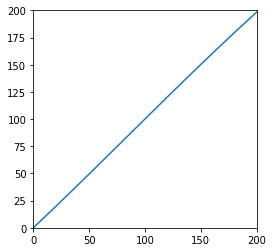

In [163]:
class TimetoVec(nn.Module):
    def __init__(self, d_model):
        super().__init__()

        self.Wt = nn.Linear(1, d_model, bias=True)
        self.d_model = d_model

    def forward(self, eventype, time):
        t2v = self.Wt(time.unsqueeze(-1))/math.sqrt(self.d_model)
        t2v[:, :, 1:] = torch.sin(t2v[:, :, 1:].clone())

        return t2v
    
t2v = TimetoVec(128)
for p in t2v.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

times = torch.arange(0,200,0.01).unsqueeze(0)
time_0 = torch.zeros(times.size()).to(times.device)

optimizer = optim.Adam(filter(lambda x: x.requires_grad, t2v.parameters()),
0.005, betas=(0.9, 0.999), eps=1e-05, weight_decay=0)


losses = []
epochs =[]
for i in range(2500):
    
    optimizer.zero_grad()
    enc_0 = t2v(None,time_0)
    embeddings =   t2v(None,times)
    embedding_distances =torch.abs(embeddings-enc_0 ).sum(dim=-1)
    time_distances = torch.abs(times - time_0)

    linearity_loss = torch.abs(embedding_distances -time_distances)
    linearity_loss = linearity_loss.mean()
    
    if i % 50 ==0:
        print(f' Epoch:{i}, Loss:{linearity_loss}')

    losses.append(linearity_loss)
    epochs.append(i)
    linearity_loss.backward()
    optimizer.step()
    
    
embeddings =   t2v(None,times)
s = torch.abs(embeddings[0] - embeddings[0][0]).sum(-1).detach()
d = times[0] 


fig, ax1 = plt.subplots(1, 1,figsize=(4,4))
ax1.plot(d,s)
ax1.set_xlim(0, 200)
ax1.set_ylim(0, 200)

In [165]:
torch.save(t2v.state_dict(),'trained_embeddings/timetovec128.pt')

 Epoch:0, Loss:63.541656494140625
 Epoch:50, Loss:50.00931930541992
 Epoch:100, Loss:46.01958084106445
 Epoch:150, Loss:41.79099655151367
 Epoch:200, Loss:38.08133316040039
 Epoch:250, Loss:34.354881286621094
 Epoch:300, Loss:30.60275650024414
 Epoch:350, Loss:26.82326889038086
 Epoch:400, Loss:23.01772689819336
 Epoch:450, Loss:19.18914794921875
 Epoch:500, Loss:15.341670036315918
 Epoch:550, Loss:11.516496658325195
 Epoch:600, Loss:8.468400001525879
 Epoch:650, Loss:6.2836408615112305
 Epoch:700, Loss:4.644222259521484
 Epoch:750, Loss:3.7207698822021484
 Epoch:800, Loss:3.0934152603149414
 Epoch:850, Loss:2.555903911590576
 Epoch:900, Loss:2.099543571472168
 Epoch:950, Loss:1.8438771963119507
 Epoch:1000, Loss:1.8034240007400513
 Epoch:1050, Loss:1.3248558044433594
 Epoch:1100, Loss:1.0275154113769531
 Epoch:1150, Loss:1.0226480960845947
 Epoch:1200, Loss:0.7578374147415161
 Epoch:1250, Loss:0.7804187536239624
 Epoch:1300, Loss:0.5601692795753479
 Epoch:1350, Loss:0.5732160210609436

(0.0, 200.0)

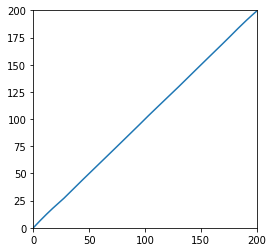

In [166]:
class TimetoVec(nn.Module):
    def __init__(self, d_model):
        super().__init__()

        self.Wt = nn.Linear(1, d_model, bias=True)
        self.d_model = d_model

    def forward(self, eventype, time):
        t2v = self.Wt(time.unsqueeze(-1))/math.sqrt(self.d_model)
        t2v[:, :, 1:] = torch.sin(t2v[:, :, 1:].clone())

        return t2v
    
t2v = TimetoVec(64)
for p in t2v.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

times = torch.arange(0,200,0.01).unsqueeze(0)
time_0 = torch.zeros(times.size()).to(times.device)

optimizer = optim.Adam(filter(lambda x: x.requires_grad, t2v.parameters()),
0.005, betas=(0.9, 0.999), eps=1e-05, weight_decay=0)


losses = []
epochs =[]
for i in range(2500):
    
    optimizer.zero_grad()
    enc_0 = t2v(None,time_0)
    embeddings =   t2v(None,times)
    embedding_distances =torch.abs(embeddings-enc_0 ).sum(dim=-1)
    time_distances = torch.abs(times - time_0)

    linearity_loss = torch.abs(embedding_distances -time_distances)
    linearity_loss = linearity_loss.mean()
    
    if i % 50 ==0:
        print(f' Epoch:{i}, Loss:{linearity_loss}')

    losses.append(linearity_loss)
    epochs.append(i)
    linearity_loss.backward()
    optimizer.step()
    
    
embeddings =   t2v(None,times)
s = torch.abs(embeddings[0] - embeddings[0][0]).sum(-1).detach()
d = times[0] 


fig, ax1 = plt.subplots(1, 1,figsize=(4,4))
ax1.plot(d,s)
ax1.set_xlim(0, 200)
ax1.set_ylim(0, 200)

In [167]:
torch.save(t2v.state_dict(),'trained_embeddings/timetovec64.pt')

 Epoch:0, Loss:82.15733337402344
 Epoch:50, Loss:73.96256256103516
 Epoch:100, Loss:69.16724395751953
 Epoch:150, Loss:64.0753173828125
 Epoch:200, Loss:58.86579513549805
 Epoch:250, Loss:53.90190124511719
 Epoch:300, Loss:48.94499206542969
 Epoch:350, Loss:43.71575927734375
 Epoch:400, Loss:38.7224235534668
 Epoch:450, Loss:33.95943069458008
 Epoch:500, Loss:29.725631713867188
 Epoch:550, Loss:25.756858825683594
 Epoch:600, Loss:22.116703033447266
 Epoch:650, Loss:18.800579071044922
 Epoch:700, Loss:15.712026596069336
 Epoch:750, Loss:12.793140411376953
 Epoch:800, Loss:10.004809379577637
 Epoch:850, Loss:7.395219326019287
 Epoch:900, Loss:5.303285121917725
 Epoch:950, Loss:3.988701581954956
 Epoch:1000, Loss:3.531954288482666
 Epoch:1050, Loss:3.4026577472686768
 Epoch:1100, Loss:3.1800992488861084
 Epoch:1150, Loss:3.091186046600342
 Epoch:1200, Loss:3.0558698177337646
 Epoch:1250, Loss:2.9520766735076904
 Epoch:1300, Loss:2.885136604309082
 Epoch:1350, Loss:2.8611509799957275
 Epoc

(0.0, 200.0)

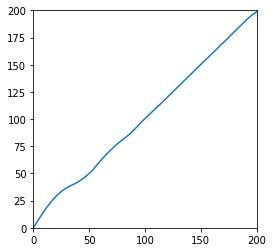

In [169]:
class TimetoVec(nn.Module):
    def __init__(self, d_model):
        super().__init__()

        self.Wt = nn.Linear(1, d_model, bias=True)
        self.d_model = d_model

    def forward(self, eventype, time):
        t2v = self.Wt(time.unsqueeze(-1))/math.sqrt(self.d_model)
        t2v[:, :, 1:] = torch.sin(t2v[:, :, 1:].clone())

        return t2v
    
t2v = TimetoVec(32)
for p in t2v.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

times = torch.arange(0,200,0.01).unsqueeze(0)
time_0 = torch.zeros(times.size()).to(times.device)

optimizer = optim.Adam(filter(lambda x: x.requires_grad, t2v.parameters()),
0.005, betas=(0.9, 0.999), eps=1e-05, weight_decay=0)


losses = []
epochs =[]
for i in range(2500):
    
    optimizer.zero_grad()
    enc_0 = t2v(None,time_0)
    embeddings =   t2v(None,times)
    embedding_distances =torch.abs(embeddings-enc_0 ).sum(dim=-1)
    time_distances = torch.abs(times - time_0)

    linearity_loss = torch.abs(embedding_distances -time_distances)
    linearity_loss = linearity_loss.mean()
    
    if i % 50 ==0:
        print(f' Epoch:{i}, Loss:{linearity_loss}')

    losses.append(linearity_loss)
    epochs.append(i)
    linearity_loss.backward()
    optimizer.step()
    
    
embeddings =   t2v(None,times)
s = torch.abs(embeddings[0] - embeddings[0][0]).sum(-1).detach()
d = times[0] 


fig, ax1 = plt.subplots(1, 1,figsize=(4,4))
ax1.plot(d,s)
ax1.set_xlim(0, 200)
ax1.set_ylim(0, 200)

In [170]:
torch.save(t2v.state_dict(),'trained_embeddings/timetovec32.pt')

 Epoch:0, Loss:80.89544677734375
 Epoch:50, Loss:74.4186019897461
 Epoch:100, Loss:67.9933090209961
 Epoch:150, Loss:61.410526275634766
 Epoch:200, Loss:54.89236068725586
 Epoch:250, Loss:48.51838302612305
 Epoch:300, Loss:42.332637786865234
 Epoch:350, Loss:36.34716033935547
 Epoch:400, Loss:30.508075714111328
 Epoch:450, Loss:24.779260635375977
 Epoch:500, Loss:19.18301010131836
 Epoch:550, Loss:13.793835639953613
 Epoch:600, Loss:9.045117378234863
 Epoch:650, Loss:6.0162787437438965
 Epoch:700, Loss:4.834778308868408
 Epoch:750, Loss:4.662786483764648
 Epoch:800, Loss:4.5789265632629395
 Epoch:850, Loss:4.49665641784668
 Epoch:900, Loss:4.418323993682861
 Epoch:950, Loss:4.353588104248047
 Epoch:1000, Loss:4.27760648727417
 Epoch:1050, Loss:4.202138423919678
 Epoch:1100, Loss:4.137216567993164
 Epoch:1150, Loss:4.089880466461182
 Epoch:1200, Loss:4.027767181396484
 Epoch:1250, Loss:3.9700026512145996
 Epoch:1300, Loss:3.9021081924438477
 Epoch:1350, Loss:3.8408491611480713
 Epoch:14

(0.0, 200.0)

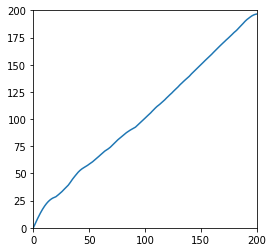

In [171]:
class TimetoVec(nn.Module):
    def __init__(self, d_model):
        super().__init__()

        self.Wt = nn.Linear(1, d_model, bias=True)
        self.d_model = d_model

    def forward(self, eventype, time):
        t2v = self.Wt(time.unsqueeze(-1))/math.sqrt(self.d_model)
        t2v[:, :, 1:] = torch.sin(t2v[:, :, 1:].clone())

        return t2v
    
t2v = TimetoVec(16)
for p in t2v.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

times = torch.arange(0,200,0.01).unsqueeze(0)
time_0 = torch.zeros(times.size()).to(times.device)

optimizer = optim.Adam(filter(lambda x: x.requires_grad, t2v.parameters()),
0.005, betas=(0.9, 0.999), eps=1e-05, weight_decay=0)


losses = []
epochs =[]
for i in range(2500):
    
    optimizer.zero_grad()
    enc_0 = t2v(None,time_0)
    embeddings =   t2v(None,times)
    embedding_distances =torch.abs(embeddings-enc_0 ).sum(dim=-1)
    time_distances = torch.abs(times - time_0)

    linearity_loss = torch.abs(embedding_distances -time_distances)
    linearity_loss = linearity_loss.mean()
    
    if i % 50 ==0:
        print(f' Epoch:{i}, Loss:{linearity_loss}')

    losses.append(linearity_loss)
    epochs.append(i)
    linearity_loss.backward()
    optimizer.step()
    
    
embeddings =   t2v(None,times)
s = torch.abs(embeddings[0] - embeddings[0][0]).sum(-1).detach()
d = times[0] 


fig, ax1 = plt.subplots(1, 1,figsize=(4,4))
ax1.plot(d,s)
ax1.set_xlim(0, 200)
ax1.set_ylim(0, 200)

(0.0, 5.0)

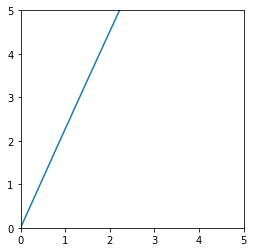

In [172]:
fig, ax1 = plt.subplots(1, 1,figsize=(4,4))
ax1.plot(d,s)
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 5)

In [173]:
torch.save(t2v.state_dict(),'trained_embeddings/timetovec16.pt')

In [ ]:
embeddings =   t2v(None,times)
s = torch.abs(embeddings[0] - embeddings[0][0]).sum(-1).detach()
d = times[0] 


fig, ax1 = plt.subplots(1, 1,figsize=(4,4))
ax1.plot(d,s)
ax1.set_xlim(0, 200)
ax1.set_ylim(0, 200)

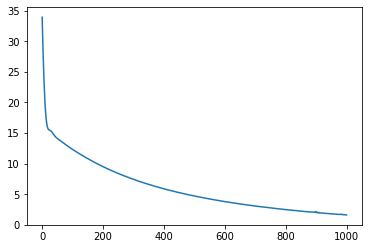

In [150]:
plt.plot(epochs,losses)

In [151]:
torch.save(t2v.state_dict(),'trained_embeddings/timetovec.pt')

(0.0, 200.0)

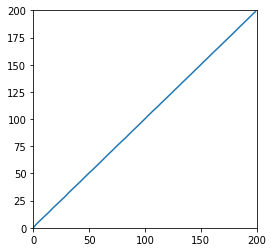

In [5]:
times = torch.arange(0,200,1.0).unsqueeze(0)


(0.0, 5.0)

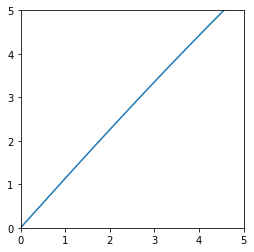

In [22]:

embeddings =   t2v(None,times)
s = torch.abs(embeddings[0] - embeddings[0][0]).sum(-1).detach()
d = times[0] 


fig, ax1 = plt.subplots(1, 1,figsize=(4,4))
ax1.plot(d,s)
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 5)

## Intensity + Kernel Gate

In [5]:
sahp.one_hot_embedding(batch_seq_types, model.input_size)

NameError: name 'batch_seq_types' is not defined